# Generating a map of *Eucalyptus* and *Pinus* planted forests in Brazil

## This code gets data from the Brazilian Institute of Geography and Statistics (IBGE), regarding state borders and the distribution of planted forest for wood and cellulose in the country. 

### First step: get Brazilian borders from IBGE API

Import libraries needed for connecting to IBGE and to proceess georreferenced data.

In [1]:
import requests
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

**Note**: While building this code, I've found another option to get Brazilian border, via the `geobr` library, from the Brazilian Institute for Applied Economic Research (IPEA). In here, I will keep using the IBGE API connection, but it is good to keep the `geobr` option in mind for similar applications.  

Get Brazil state borders via IBGE API. The query url has been generated by the query builder available at IBGE's website https://servicodados.ibge.gov.br/api/docs/malhas?versao=3#api-bq

It sets the API to deliver data in topojson format, at maximum available quality, for all states in Brazil.

In [2]:
ibge_api_url = 'https://servicodados.ibge.gov.br/api/v3/malhas/paises/BR?formato=application/json&qualidade=maxima&intrarregiao=UF'

r = requests.get(ibge_api_url) 
r.status_code # Check if connection was successful

200

Save json data, open it with `geopandas`

<AxesSubplot:title={'center':'Yearly mean of daily GHI totals'}>

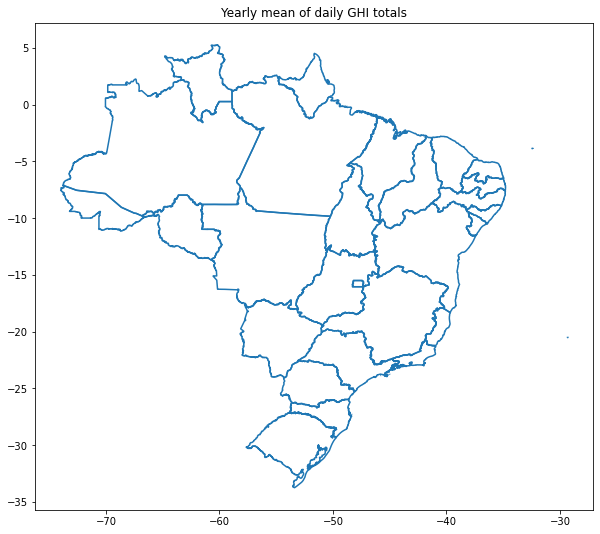

In [3]:
%%capture --no-display 
# geopandas would show some warnings here, turned them off

# Save .json file
json_data = json.loads(r.content) #(r.content)
filename = "br_state_borders.json"

with open(filename, 'w') as json_file:
    json.dump(json_data, json_file)   
    json_file.close()    

# Open file with geopandas
br_state_borders = gpd.GeoDataFrame.from_file(filename)

# Plot borders to check if everything is OK
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.title('Yearly mean of daily GHI totals')
br_state_borders.boundary.plot(ax=ax)

### Now that country borders are available, time to get vegetation cover data.

This data was manually downloaded from the IBGE's BDIA application (https://bdiaweb.ibge.gov.br/#/consulta/vegetacao), as it was not available via API.

Let's open it with `geopandas` and see what's inside

In [4]:
veg_cover_data = gpd.read_file('vege_area/vege_area.shp')
veg_cover_data.head()

,id1,cd_fcim,leg_carga,cd_fito,cd_leg_2,clas_domi,leg_uveg,nm_uveg,leg_uantr,nm_uantr,...,leg_sec2,nm_sec2,leg_sup,legenda_1,legenda_2,legenda,ar_poli_km,leg1_id,leg2_id,geometry
0,415157,NA19,Asp+Dse,A,As,Asp,Asp,Floresta Ombrófila Aberta Submontana com palme...,None,None,...,None,None,Vegetação Natural Dominante,Floresta Ombrófila Aberta,Floresta Ombrófila Aberta Submontana,1Asp - Floresta Ombrófila Aberta Submontana co...,80.9839,2.0,8.0,"POLYGON ((-67.81741 0.55434, -67.81754 0.55368..."
1,415156,NA19,Asp+rsb,A,As,Asp,Asp,Floresta Ombrófila Aberta Submontana com palme...,None,None,...,None,None,Vegetação Natural Dominante,Floresta Ombrófila Aberta,Floresta Ombrófila Aberta Submontana,1Asp - Floresta Ombrófila Aberta Submontana co...,2.7161,2.0,8.0,"POLYGON ((-67.82611 0.49868, -67.82787 0.49802..."
2,414710,NA19,Asp+Dse,A,As,Asp,Asp,Floresta Ombrófila Aberta Submontana com palme...,None,None,...,None,None,Vegetação Natural Dominante,Floresta Ombrófila Aberta,Floresta Ombrófila Aberta Submontana,1Asp - Floresta Ombrófila Aberta Submontana co...,477.8371,2.0,8.0,"POLYGON ((-69.67986 1.60020, -69.68240 1.59620..."
3,415136,NA19,Asp+Dse,A,As,Asp,Asp,Floresta Ombrófila Aberta Submontana com palme...,None,None,...,None,None,Vegetação Natural Dominante,Floresta Ombrófila Aberta,Floresta Ombrófila Aberta Submontana,1Asp - Floresta Ombrófila Aberta Submontana co...,3.8990,2.0,8.0,"POLYGON ((-67.74775 0.38659, -67.74775 0.38501..."
4,415135,NA19,Asp+Dse,A,As,Asp,Asp,Floresta Ombrófila Aberta Submontana com palme...,None,None,...,None,None,Vegetação Natural Dominante,Floresta Ombrófila Aberta,Floresta Ombrófila Aberta Submontana,1Asp - Floresta Ombrófila Aberta Submontana co...,17.8210,2.0,8.0,"POLYGON ((-67.81861 0.46498, -67.81463 0.45865..."


For a complete description of the contents in the file, check https://bdiaweb.ibge.gov.br/#/sobre/vegetacao (I'm afraid it's only available in Portuguese...)

Of interest to us is the **leg_uantr** column, which contains the register of man-made vegetal land cover, i.e., planted areas. We are interested in areas registered by the strings `'Re'` (eucalyptus reforestation areas) and `'Rp'` (pinus reforestation areas)

In [5]:
idx = veg_cover_data.leg_uantr.isin(['Re','Rp'])
planted_forests_data = veg_cover_data[idx.values]
planted_forests_data.head()

,id1,cd_fcim,leg_carga,cd_fito,cd_leg_2,clas_domi,leg_uveg,nm_uveg,leg_uantr,nm_uantr,...,leg_sec2,nm_sec2,leg_sup,legenda_1,legenda_2,legenda,ar_poli_km,leg1_id,leg2_id,geometry
4361,449949,NA22,Re+Rp+Spf,S,R,Re,None,None,Re,Florestamento/Reflorestamento com Eucaliptos,...,Spf,Savana Parque com floresta-de-galeria,Área Antrópica Dominante,Savana,Florestamento/Reflorestamento,3Re - Florestamento/Reflorestamento com Eucali...,1554.6365,8.0,50.0,"POLYGON ((-50.93466 0.79470, -50.93352 0.79310..."
4362,443677,NA22,Re+Rp.S,S,R,Re,None,None,Re,Florestamento/Reflorestamento com Eucaliptos,...,None,None,Área Antrópica Dominante,Savana,Florestamento/Reflorestamento,3Re - Florestamento/Reflorestamento com Eucali...,2.1780,8.0,50.0,"POLYGON ((-50.90866 0.26545, -50.90972 0.26403..."
4363,443373,NA22,Re+Spf+Sd,S,R,Re,None,None,Re,Florestamento/Reflorestamento com Eucaliptos,...,Sd,Savana Florestada,Área Antrópica Dominante,Savana,Florestamento/Reflorestamento,3Re - Florestamento/Reflorestamento com Eucali...,10.3542,8.0,50.0,"POLYGON ((-50.91649 1.53237, -50.91750 1.53079..."
4364,443235,NA22,Rp+Re.S,S,R,Rp,None,None,Rp,Florestamento/Reflorestamento com Pinus,...,None,None,Área Antrópica Dominante,Savana,Florestamento/Reflorestamento,3Rp - Florestamento/Reflorestamento com Pinus,3.8471,8.0,50.0,"POLYGON ((-51.03068 0.42273, -51.03192 0.42081..."
16552,444948,SA22,Re.D,D,R,Re,None,None,Re,Florestamento/Reflorestamento com Eucaliptos,...,None,None,Área Antrópica Dominante,Floresta Ombrófila Densa,Florestamento/Reflorestamento,3Re - Florestamento/Reflorestamento com Eucali...,1.5454,1.0,50.0,"POLYGON ((-49.34144 -3.47316, -49.34184 -3.479..."


Now we can plot both the country and state borders, well as the planted forests within it.

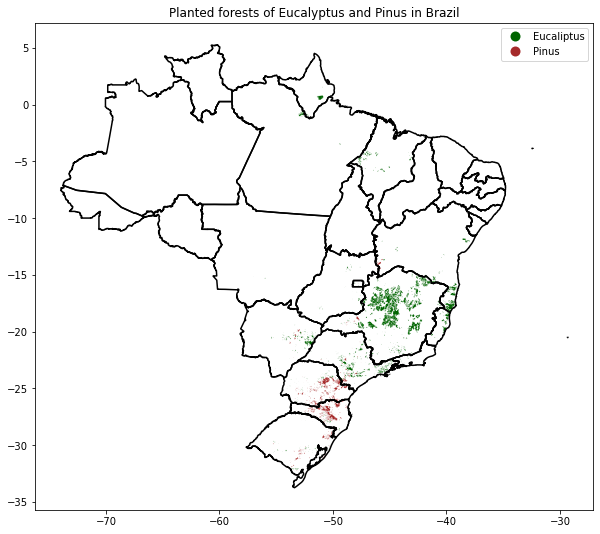

In [6]:
%%capture --no-display 
# geopandas would show some warnings here, turned them off

# Plot final map
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.title('Planted forests of Eucalyptus and Pinus in Brazil')
br_state_borders.boundary.plot(ax=ax, color='black')

# Set proper labels areas of eucalyptus and of pinus
planted_forests_data.insert(len(planted_forests_data.columns),'Label',' ') # Insert new column
planted_forests_data.loc[planted_forests_data.leg_uantr == 'Re','Label'] = 'Eucaliptus' # Assign labels to eucalyptus areas
planted_forests_data.loc[planted_forests_data.leg_uantr == 'Rp','Label'] = 'Pinus' # Assign labels to pinus areas

# Plot planted areas
planted_forests_data.plot(column = 'Label', ax=ax, legend=True, 
                                        cmap = matplotlib.colors.ListedColormap(['darkgreen','brown']))

plt.savefig('BR_planted_forests_map.png')